### Clustered Sampling

You're working at a food delivery company, like Deliveroo ;). You get together with your product manager to discuss a  feature to improve the customer experience after an order has been placed. You go ahead and design this feature and work with the engineers on your team to implement it. You run an experiment with the aim of decreasing the number of customers calling customer service, randomised on a customer-level.

Once you've collected the required sample size, you begin to analyse the results. Your company typically quantifies cost on an order basis - in this case, customer service cost per order. Our experiments was randomised on the customer-level but we're now analysing it on the order-level. We know that we need to be careful as the unit of diversion and the unit of analysis are different (link to other blog post), but are unsure how we can correct for this and obtain robust results. 

Here we'll explore cluster-robust regression which can be used to correctly analyse experiments when the unit of diversion and unit of analysis are different. When we learn statistics, we nearly always make the assumption that our data is independent and identically distributed (iid). In clustered sampling, observations are grouped into clusters. The clusters can be treated as independent, but within each cluster the data is dependent. 

We'll begin by writing a function that generates multiple, correlated data points per user and afterwards analyse the false positive rate that we obtain from this.

In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
import seaborn as sns

### Generate some data

We can use the multivariate normal distribution to generate some data. We can specify the intra-cluster correlation using the covariance matrix, `sigma_i` and `sigma_cl` below.

The intra-cluster correlation is specified by `rho`. When `rho = 0`, the intra-cluster correlation is zero and all samples can be treated as if independent. When `rho = 1`, all samples within a cluster are treated as if identical.

In [205]:
def generate_cluster_data (b0, b1, n, n_cluster, rho):
    # function adapted from http://yukiyanai.github.io/teaching/rm1/contents/R/clustered-data-analysis.html
    
    # individual level
    mean_i = [1,1]
    sigma_i = np.matrix([[1,0], [0, 1-rho]])
    values_i = np.random.multivariate_normal(mean_i, sigma_i, size=n)

    # cluster level
    cluster_name = np.arange(n_cluster)
    cluster_name = np.repeat(cluster_name, n / n_cluster, axis=0)
    mean_cl = [1,1]
    sigma_cl = np.matrix([[1,0], [0, rho]])
    values_cl = np.random.multivariate_normal(mean_cl, sigma_cl, size=n_cluster)
   
    # predictor var consists of individual-level and cluster-level components
    x = values_i[:, 0] + np.repeat(values_cl[:, 0], n / n_cluster, axis=0)

    # error consists of individual- and cluster-level components
    error = values_i[:, 1] + np.repeat(values_cl[:, 1], n / n_cluster, axis=0)

    # data generating process
    y = b0 + b1*x + error
    data = np.stack([x,y,cluster_name], axis=1)
    columns = ['x', 'y', 'cluster_id']
    df = pd.DataFrame(data, columns = columns)
    
    return(df)

### Plot an example dataset

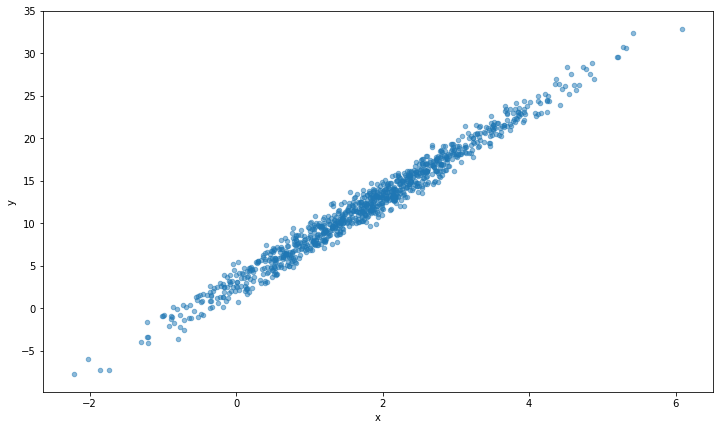

In [206]:
df = generate_cluster_data(1,5,1000, 50,0.5)
df.plot.scatter(x='x', y='y', figsize=(12,7), alpha=.5);

In our example above, our experiment dataset would look something like this:
    
| order_id | customer_id | variant | cs_cost |
|----------|-------------|---------|---------|
| 1        | 1           | control | 2       |
| 2        | 1           | control | 0       |
| 3        | 2           | variant | 2.5     |

We would then run a regression to determine the mean effect of the feature on customer service costs per order.

Using statsmodels and specifying the covariance type to cluster, we would run the following and then assess the coefficient value `beta_1`
```python
X = np.where(df['variant'] == 'feature', 1, 0)
X = sm.add_constant(X)
Y = df['cs_cost']

results = OLS(Y,X).fit(cov_type='cluster', cov_kwds={'groups': df['customer_id']})
```

### Let's write some more code to simulate a regression multiple times

In our example, we can explore the effect of using cluster robust variance by simulating thousands of datasets and running A/A tests.

We begin by writing two more functions, then we'll examine the effect of clustered data on our conclusions.

In [207]:
# Simulate a dataset with clusters and fit OLS
def regress(b0, b1, n, n_cluster, rho, cluster_robust):
    
    df = generate_cluster_data (b0, b1, n, n_cluster, rho)
    
    # fit a regression
    X = df['x']
    X = sm.add_constant(X)
    Y = df['y']

    if cluster_robust:
        m = OLS(Y, X).fit(cov_type='cluster', cov_kwds={'groups': df['cluster_id']})
    else:
        m = OLS(Y, X).fit()

    b1 = m.params['x']
    b1_ci95 = m.conf_int().loc['x', :]
    b1_ci95_low, b1_ci95_hi = b1_ci95[0], b1_ci95[1]
    return [b1, b1_ci95_low, b1_ci95_hi]
    
# let's run this simulation multiple times
def simulate(b0, b1, n, n_cluster, rho, cluster_robust, nsims):
    data = []
    for _ in range(nsims):
        data.append(regress(b0, b1, n, n_cluster, rho, cluster_robust))
    columns = ['b1', 'b1_ci95_low', 'b1_ci95_hi']
    return pd.DataFrame(data, columns=columns)  

### Let's first generate some data with no intra-cluster correlation

We will set `beta_1` to 0, meaning that our output `y` is not a function of `x`. 

In [208]:
b0 = 5
b1 = 0
n = 1000
n_cluster = 50
rho = 0
cluster_robust = False
nsims = 5000

df = simulate(b0, b1, n, n_cluster, rho, cluster_robust, nsims)

### Let's plot the distribution of `beta_1`

/Users/iwanthomas/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


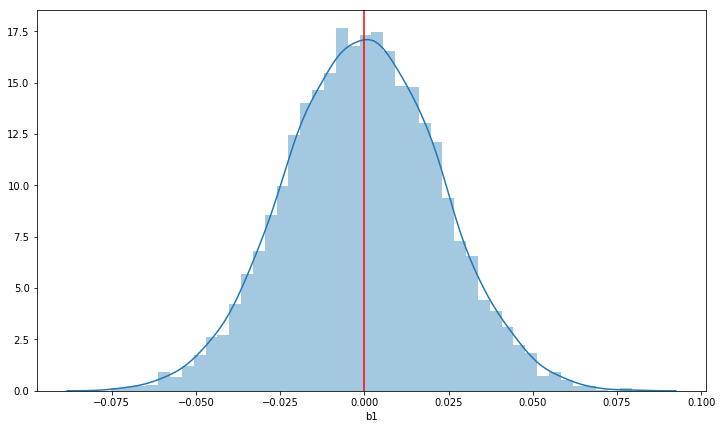

In [209]:
fig, ax = plt.subplots(1,1,figsize=(12,7))
sns.distplot(df['b1'], ax=ax)
ax.axvline(x=0, color='r', linestyle='-')

### Does the CI contain the true parameter value 95% of the time?

Setting the significance level at 5%, we should incorrectly reject the null `beta_1 = 0` in about 5 percent of the simulations. We can see below that the CI does contain the true parameter value 95% of the time.

In [210]:
df['within_ci'] = (df['b1_ci95_low'] <= b1) & (df['b1_ci95_hi'] >= b1)
print ('CI contains true parameter {:.2f} of the time'.format(df['within_ci'].mean() * 100))

CI contains true parameter 95.26 of the time


### Let's generate some data with intra-cluster correlation

What would be the impact of this intra-cluster correlation when cluster robust variance isn't used?

In [211]:
# update this values
rho = 0.5

df = simulate(b0, b1, n, n_cluster, rho, cluster_robust, nsims)

/Users/iwanthomas/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


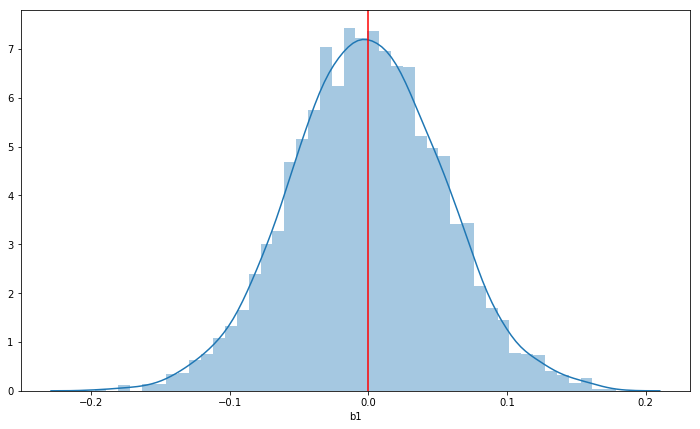

In [212]:
fig, ax = plt.subplots(1,1,figsize=(12,7))
sns.distplot(df['b1'], ax=ax)
ax.axvline(x=0, color='r', linestyle='-')

In [213]:
df['within_ci'] = (df['b1_ci95_low'] <= b1) & (df['b1_ci95_hi'] >= b1)
print ('CI contains true parameter {:.2f} of the time'.format(df['within_ci'].mean() * 100))

CI contains true parameter 58.02 of the time


Whilst on average we can estimate the true parameter value, `beta_1`, our ability to do this for each case is compromised as shown by the inflated type I error rate. This is due to the increased variability of our estimates now (just compare the width of the distribution above with the one generated from uncorrelated data) and our underestimation of the standard error.

### Let's generate some data with intra-cluster correlation

This time, let's use cluster_robust regression.

In [214]:
# update these values
rho = 0.5
cluster_robust = True

df = simulate(b0, b1, n, n_cluster, rho, cluster_robust, nsims)

/Users/iwanthomas/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


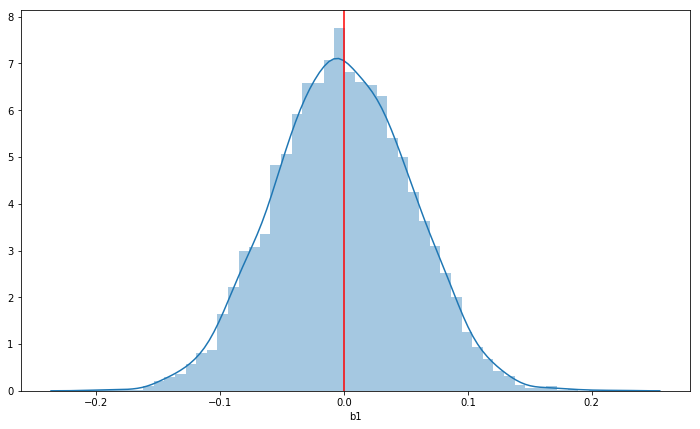

In [215]:
fig, ax = plt.subplots(1,1,figsize=(12,7))
sns.distplot(df['b1'], ax=ax)
ax.axvline(x=0, color='r', linestyle='-')

In [216]:
df['within_ci'] = (df['b1_ci95_low'] <= b1) & (df['b1_ci95_hi'] >= b1)
print ('CI contains true parameter {:.2f} of the time'.format(df['within_ci'].mean() * 100))

CI contains true parameter 92.78 of the time


By using the cluster-robust variance estimator, we once again obtain the correct type I error rate. Notice how the distribution is still wider than the first distribution that was plotted (which had an intra-cluster correlation of 0). By using the cluster-robust variance estimator, we correctly estimate the standard error.

### Conclusions

Analysing correlated data under the assumption, such as that which arises from experiments with different units of diversion and analysis, can lead to unreliable results. 

(link to other blog post) described this issue in detail, but didn't offer much in the way of solutions. Cluster-robust regression is one such solution that can help overcome this challenge and robustly analyse clustered data.

### Resources

http://yukiyanai.github.io/teaching/rm1/contents/R/clustered-data-analysis.html